<a href="https://colab.research.google.com/github/theofarouk/IMDA/blob/main/Time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series analysis (LSTM, 1D-CNN, 2D-CNN, …)
The aim of this lab (TP) is to a classification system of Human Activity Recognition (HAR).
The data used for classification is provided by the Wireless Sensor Data Mining (WISDM) Lab and can be downloaded directly from the course platform “actitracker_raw.txt”. It consists of 1,098,207 examples of various physical activities (sampled at 20Hz) with 6 attributes: user,activity,timestamp,x-acceleration,y-acceleration,z-acceleration.
The activities include: Walking, Jogging, Upstairs, Downstairs, Sitting, Standing.

This data comes from the [University of Fordham](https://www.cis.fordham.edu/wisdm/dataset.php) and represents the accelerometer data while doing various activities. The aim is to determine which activity is done by analysing the sequence. According to the sources, the number of samples is equal to 1,098,207 divided in 6 classes :

*   Walking: 424,400 (38.6%)
*   Jogging: 342,177 (31.2%)
*   Upstairs: 122,869 (11.2%)
*   Downstairs: 100,427 (9.1%)
*   Sitting: 59,939 (5.5%)
*   Standing: 48,395 (4.4%)


Starting by downloading the data and aploading here:
https://drive.google.com/file/d/1_pNqa6Mq9pPx5qux2FMqWllL3jqzvx_d/view?usp=sharing

We can use pandas to handle the time series. While displaying the values, we observe z-axis is not in the correct format because of the semicolon. we have to convert this data to numerical values. we can notice the presence of a NaN value so it's possible to use linear interpolation replace it.

In [12]:
import os
import pandas as pd
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyDrive: filename=PyDrive-1.3.1-py3-none-any.whl size=27433 sha256=8d1880ef0698ff55cd90d4d5c506b43d776a08afd9f3f496ca6d651262853c17
  Stored in directory: /root/.cache/pip/wheels/6c/10/da/a5b513f5b3916fc391c20ee7b4633e5cf3396d570cdd74970f
Successfully built PyDrive


Start by upload the data:

In order to show how the x-acceleration was changing with time (or more accurately - at each timestep) for each one of these activities, you can use this function:

In [14]:
# Monter votre Drive afin de pouvoir y'acceder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Machine Learning/Time_series/actitracker_raw.txt.zip', 'r') as zip_ref:
    zip_ref.extractall("actitracker_raw")

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)


def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [17]:
def readData(filePath):
    # attributes of the dataset
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data


/tmp/ipython-input-1599368035.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
/tmp/ipython-input-17820869.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  subset=subset.interpolate()
/tmp/ipython-input-17820869.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  subset=subset.interpolate()
/tmp/ipython-input-17820869.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  subset=subset.interpolate()
/tmp/ipython-input-17820869.py:4: FutureWarning: DataFrame.interpolate with object d

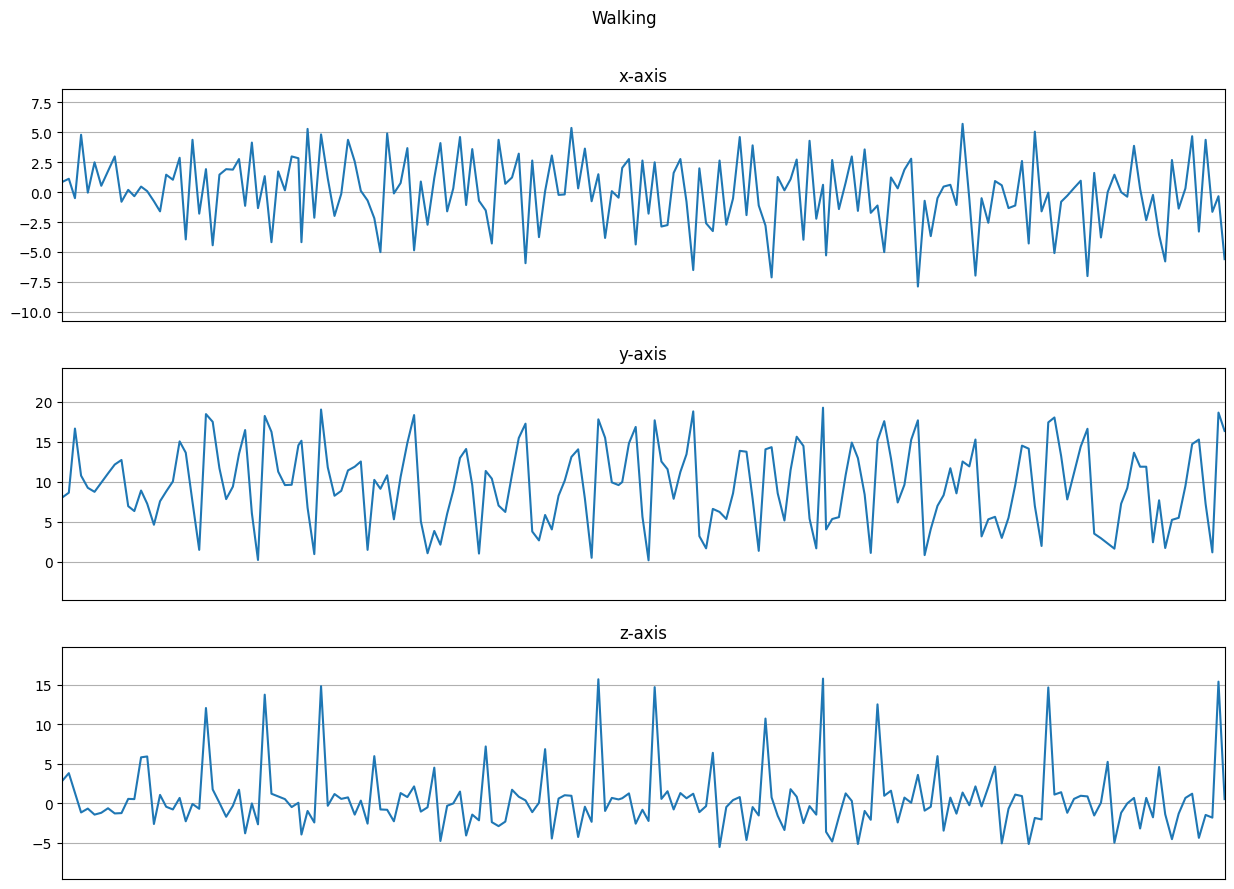

In [18]:
dataset = readData('actitracker_raw/actitracker_raw.txt')
for activity in np.unique(dataset['activity']):
  subset = dataset[dataset['activity']==activity][:180]
  subset=subset.interpolate()

plotActivity(activity,subset)

In order to feed the network with such temporal dependencies a sliding time window is used to extract separate data segments. The window width and the step size can be both adjusted and optimised for better accuracy. Each time step is associated with an activity label, so for each segment the most frequently appearing label is chosen. Here, the time segment or window width is chosen to be 90.

In [19]:
from scipy import stats
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)
# segmenting the time series
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,3))
    labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]
        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels =np.append(labels,data['activity'][start:end].mode()[0])
    return segments, labels


The data needs to be separated into features and labels and then further into training and test sets. Labels need to be one-hot encoded before feeding into the classifier. Then,split the data into train/test subset as 80%/20%: train (19522 sequences) and test (4881 sequences).


# 1. Convolutional Neural Network (2D CNN)

If you concatenate the time series columns, you obtain a 2D matrix, on which you can apply a 2D CNN based classification system. Because we want to apply a 2D CNN, it is necessary to add a dimension to our sequences.


You can download the segment files here:
https://drive.google.com/file/d/1u9Nz4-JK-tc0UZn457UX6QjHPOclyJMq/view?usp=sharing

Put it on your Drive and then read it

In [20]:
segments, labels = segment_signal(dataset)
reshapedSeg = segments.reshape(segments.shape[0], segments.shape[1], segments.shape[2],1)

In [21]:
print(np.array(segments).shape,np.array(labels).shape)

(24403, 90, 3) (24403,)


Your data contains NaN, you must replace it by numbers:

In [22]:
segments = np.nan_to_num(segments)

In [23]:
# here your code
from sklearn.model_selection import train_test_split

labels_enc = np.asarray(pd.get_dummies(labels), dtype=np.int8)
reshapedSeg = segments.reshape(segments.shape[0],
segments.shape[1], segments.shape[2], 1)

X_train, X_test, y_train, y_test = train_test_split(
    reshapedSeg, labels_enc, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(19522, 90, 3, 1) (19522, 6) (4881, 90, 3, 1) (4881, 6)


2D CNN need also that the format of labels to be in one hot encoding labels.

Here, you can propose a classification system based on a 2DCNN (you can find an example of a suggested model here:)

In [24]:
# Here your model !!!
model2D = models.Sequential([
    layers.Conv2D(128, (2, 2), activation='relu', input_shape=(90, 3, 1)),
    layers.MaxPooling2D((2, 1)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')  # 6 classes d'activités
])

model2D.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model2D.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 89, 2, 128)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 44, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 44, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,441,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,459,846 (5.57 MB)

 Trainable params: 1,459,846 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
  # Entraînement du modèle
  history_2D = model2D.fit(
      X_train, y_train,
      epochs=30,
      batch_size=32,
      validation_data=(X_test, y_test),
      verbose=1
  )

Epoch 1/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7275 - loss: 0.8861 - val_accuracy: 0.8310 - val_loss: 0.4461
Epoch 2/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8358 - loss: 0.4300 - val_accuracy: 0.8474 - val_loss: 0.3999
Epoch 3/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8575 - loss: 0.3670 - val_accuracy: 0.8736 - val_loss: 0.3446
Epoch 4/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8947 - loss: 0.2786 - val_accuracy: 0.8851 - val_loss: 0.3162
Epoch 5/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9205 - loss: 0.2143 - val_accuracy: 0.8744 - val_loss: 0.3528
Epoch 6/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9314 - loss: 0.1824 - val_accuracy: 0.9099 - val_loss: 0.2680
Epoch 7/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9423 - loss: 0.1580 - val_accuracy: 0.9162 - val_loss: 0.2733
Epoch 8/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9537 - loss: 0.1278 - val_accuracy: 0.

**Question 1**: Plot performance curves that show the evaluation of the CNN model.

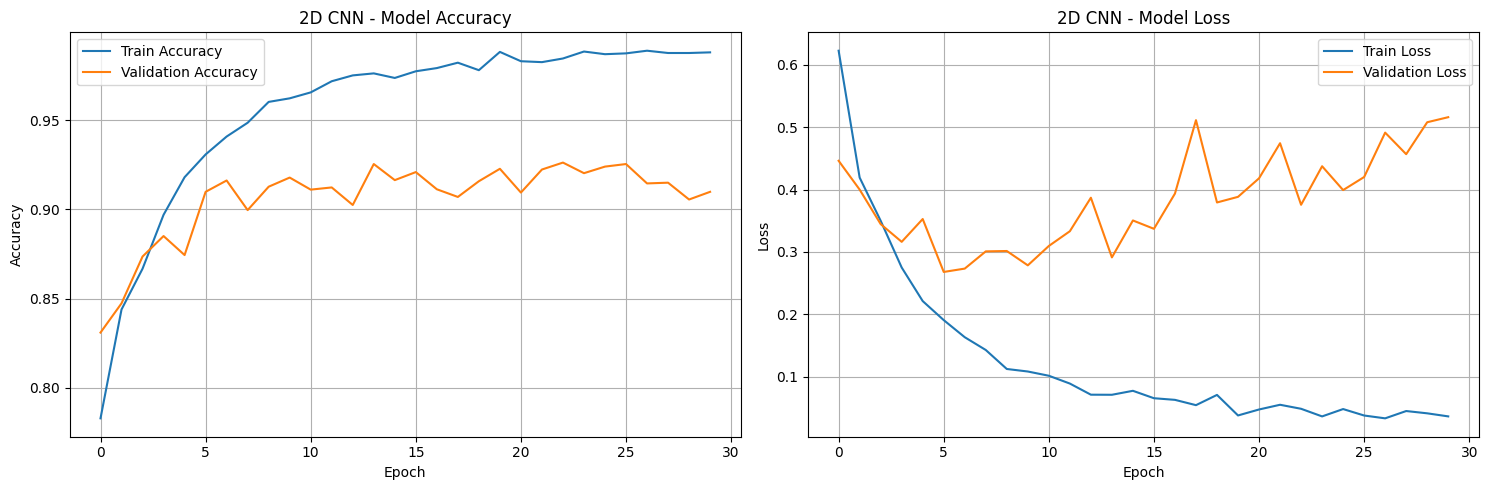


Performance finale du 2D CNN:
Train Accuracy: 0.9880
Validation Accuracy: 0.9099


In [28]:
  # Courbes de performance

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # Accuracy
  ax1.plot(history_2D.history['accuracy'], label='Train Accuracy')
  ax1.plot(history_2D.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_title('2D CNN - Model Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend()
  ax1.grid(True)

  # Loss
  ax2.plot(history_2D.history['loss'], label='Train Loss')
  ax2.plot(history_2D.history['val_loss'], label='Validation Loss')
  ax2.set_title('2D CNN - Model Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()
  plt.show()

  # Afficher les performances finales
  print(f"\nPerformance finale du 2D CNN:")
  print(f"Train Accuracy: {history_2D.history['accuracy'][-1]:.4f}")
  print(f"Validation Accuracy: {history_2D.history['val_accuracy'][-1]:.4f}")


**2.	Long-Short-Terms-Memory (LSTM)**


Configures an RNN as following:


In [29]:
# your model here

# Modèle LSTM

RNN = models.Sequential([
    # Première couche LSTM avec return_sequences=True (pour empiler des LSTM)
    layers.LSTM(128, return_sequences=True, input_shape=(90, 3)),
    layers.BatchNormalization(),

    # Deuxième couche LSTM
    layers.LSTM(128, return_sequences=False),
    layers.BatchNormalization(),

    # Couches Dense
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # 6 classes
])

RNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(RNN.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 90, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,518 (798.90 KB)

 Trainable params: 204,006 (796.90 KB)

 Non-trainable params: 512 (2.00 KB)

None


In [30]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
      segments, labels_enc, test_size=0.2, random_state=42
  )

history_LSTM = RNN.fit(
      X_train_lstm, y_train_lstm,
      epochs=10,
      batch_size=32,
      validation_data=(X_test_lstm, y_test_lstm),
      verbose=1
  )

Epoch 1/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6761 - loss: 0.9827 - val_accuracy: 0.7955 - val_loss: 0.6577
Epoch 2/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8099 - loss: 0.5335 - val_accuracy: 0.8793 - val_loss: 0.3323
Epoch 3/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8830 - loss: 0.3327 - val_accuracy: 0.9320 - val_loss: 0.2023
Epoch 4/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9102 - loss: 0.2827 - val_accuracy: 0.9457 - val_loss: 0.1570
Epoch 5/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9425 - loss: 0.1842 - val_accuracy: 0.9531 - val_loss: 0.1667
Epoch 6/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9377 - loss: 0.2061 - val_accuracy: 0.9578 - val_loss: 0.1376
Epoch 7/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9519 - loss: 0.1545 - val_accuracy: 0.9680 - val_loss: 0.1132
Epoch 8/10
611/611 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9622 - loss: 0.1275 - val_ac

**Question 2:** Plot performance curves that show the evaluation of the LSTM model and compare it to the previous CNN model.

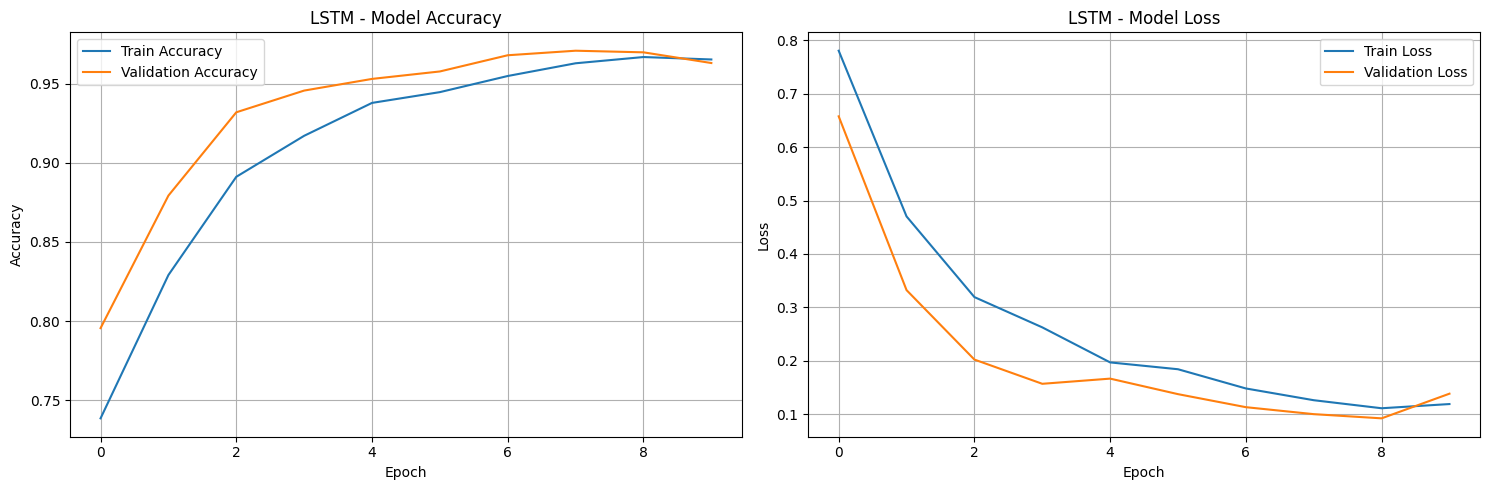


Performance finale du LSTM:
Train Accuracy:0.9654
Validation Accuracy: 0.9631


In [31]:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # Accuracy
  ax1.plot(history_LSTM.history['accuracy'], label='Train Accuracy')
  ax1.plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_title('LSTM - Model Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend()
  ax1.grid(True)

  # Loss
  ax2.plot(history_LSTM.history['loss'], label='Train Loss')
  ax2.plot(history_LSTM.history['val_loss'], label='Validation Loss')
  ax2.set_title('LSTM - Model Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()
  plt.show()

  # Performance finale
  print(f"\nPerformance finale du LSTM:")
  print(f"Train Accuracy:{history_LSTM.history['accuracy'][-1]:.4f}")
  print(f"Validation Accuracy: {history_LSTM.history['val_accuracy'][-1]:.4f}")

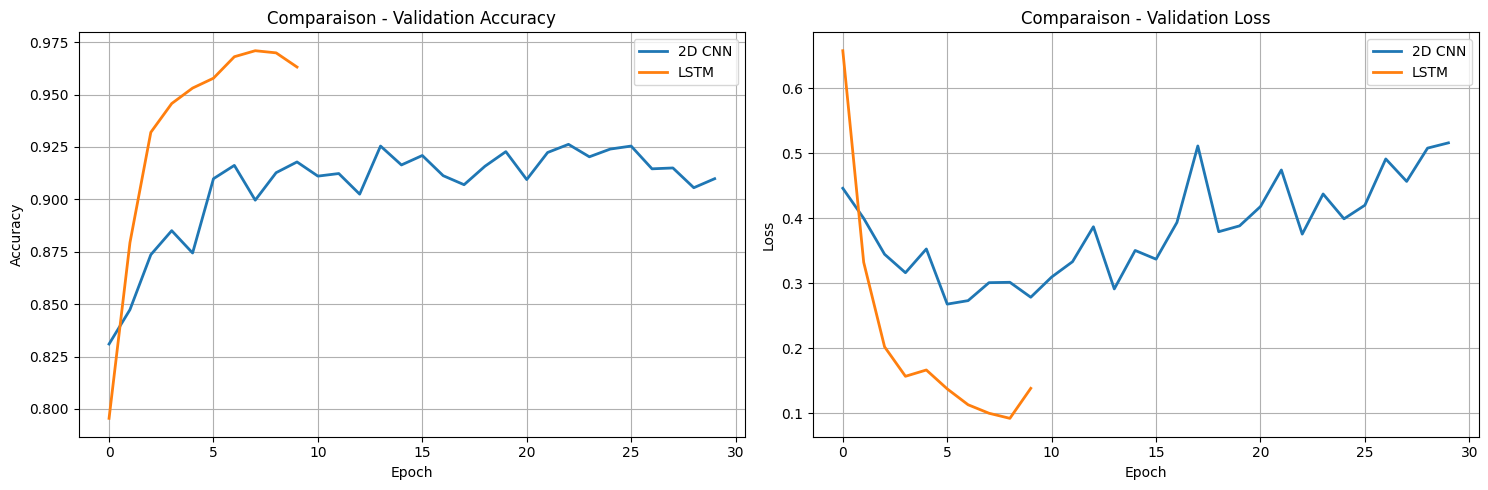

In [32]:
# Comparaison des deux modèles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Comparaison Accuracy
ax1.plot(history_2D.history['val_accuracy'], label='2D CNN',
linewidth=2)
ax1.plot(history_LSTM.history['val_accuracy'], label='LSTM',
linewidth=2)
ax1.set_title('Comparaison - Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Comparaison Loss
ax2.plot(history_2D.history['val_loss'], label='2D CNN',
linewidth=2)
ax2.plot(history_LSTM.history['val_loss'], label='LSTM',
linewidth=2)
ax2.set_title('Comparaison - Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**3. Convolutional Neural Network (1D CNN)**

1D CNN can perform activity recognition task from accelerometer data, such as if the person is standing, walking, jumping etc. This data has 2 dimensions. The first dimension is time-steps and other is the values of the acceleration in 3 axes. To add a Conv1D layer in keras for example:

In [ ]:
#from tensorflow.keras.layers import Conv1D
#model = models.Sequential()
#model.add(Conv1D(1, kernel_size=5, input_shape = (120, 3)))

In [33]:
# here your model

model1D = models.Sequential([
    # Premier bloc convolutif
    layers.Conv1D(100, kernel_size=5, activation='relu',
input_shape=(90, 3)),
    layers.Conv1D(100, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=3),

    # Deuxième bloc convolutif
    layers.Conv1D(160, kernel_size=5, activation='relu'),
    layers.Conv1D(160, kernel_size=5, activation='relu'),
    layers.GlobalAveragePooling1D(),

    # Couche de sortie
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model1D.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model1D.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 86, 100)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 82, 100)        │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 27, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 23, 160)        │        80,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 19, 160)        │       128,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 160)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,986 (1019.48 KB)

 Trainable params: 260,986 (1019.48 KB)

 Non-trainable params: 0 (0.00 B)

None


In [34]:
  # Entraînement du modèle 1D CNN
  # On utilise les mêmes données que pour LSTM (segments sans
  history_1D = model1D.fit(
      X_train_lstm, y_train_lstm,
      epochs=30,
      batch_size=32,
      validation_data=(X_test_lstm, y_test_lstm),
      verbose=1
  )

Epoch 1/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7861 - loss: 0.6164 - val_accuracy: 0.9537 - val_loss: 0.1430
Epoch 2/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9545 - loss: 0.1482 - val_accuracy: 0.9635 - val_loss: 0.1101
Epoch 3/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9714 - loss: 0.0919 - val_accuracy: 0.9590 - val_loss: 0.1205
Epoch 4/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9741 - loss: 0.0763 - val_accuracy: 0.9801 - val_loss: 0.0691
Epoch 5/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9841 - loss: 0.0552 - val_accuracy: 0.9801 - val_loss: 0.0648
Epoch 6/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9868 - loss: 0.0444 - val_accuracy: 0.9732 - val_loss: 0.0747
Epoch 7/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9857 - loss: 0.0469 - val_accuracy: 0.9799 - val_loss: 0.0734
Epoch 8/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9904 - loss: 0.0388 - val_accuracy: 

**Question 3:** Test the performance of this model and compare it to the previous models.

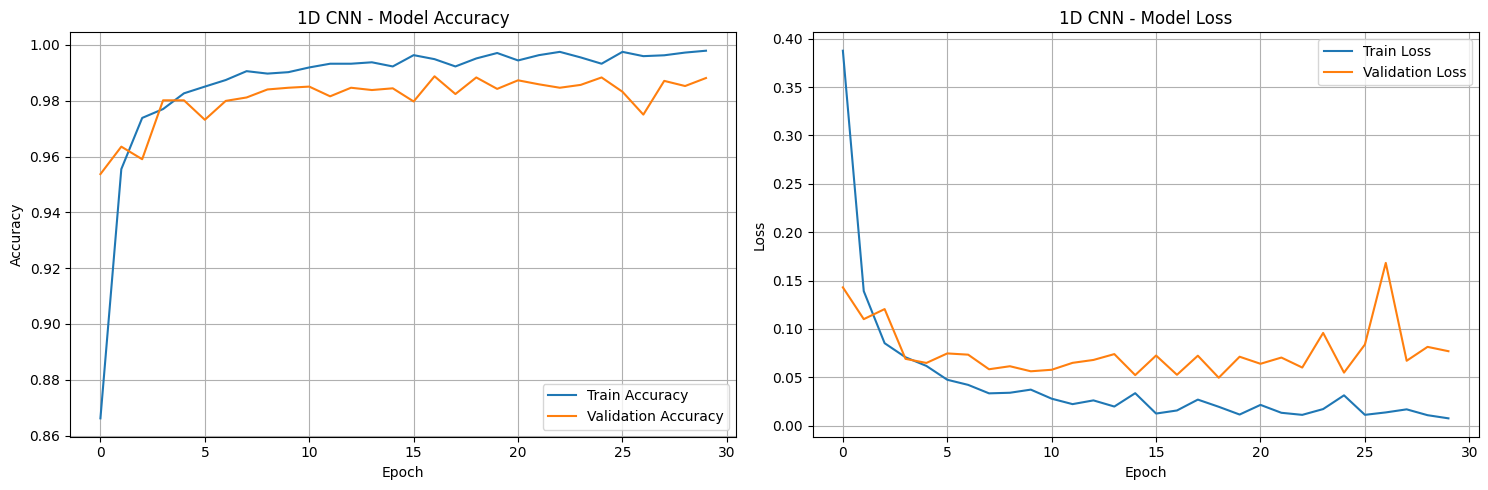


Performance finale du 1D CNN:
Train Accuracy: 0.9979
Validation Accuracy: 0.9881


In [35]:
  # Courbes de performance 1D CNN

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # Accuracy
  ax1.plot(history_1D.history['accuracy'], label='Train Accuracy')
  ax1.plot(history_1D.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_title('1D CNN - Model Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend()
  ax1.grid(True)

  # Loss
  ax2.plot(history_1D.history['loss'], label='Train Loss')
  ax2.plot(history_1D.history['val_loss'], label='Validation Loss')
  ax2.set_title('1D CNN - Model Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()
  plt.show()

  # Performance finale
  print(f"\nPerformance finale du 1D CNN:")
  print(f"Train Accuracy: {history_1D.history['accuracy'][-1]:.4f}")
  print(f"Validation Accuracy: {history_1D.history['val_accuracy'][-1]:.4f}")

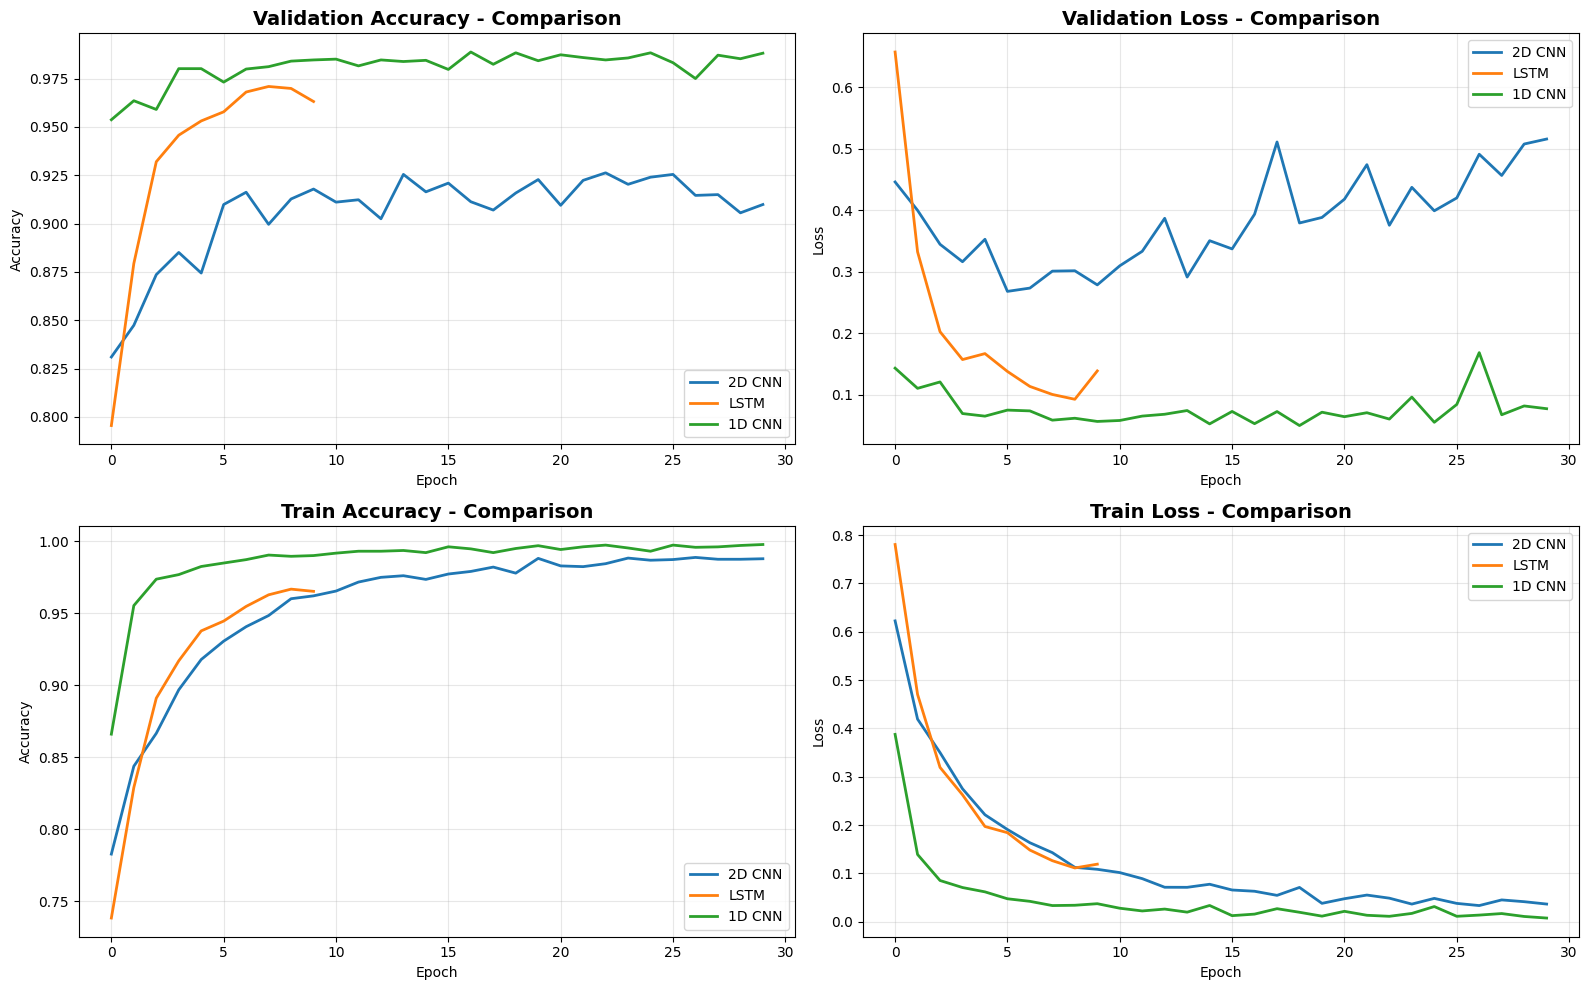

In [36]:
# Comparaison des TROIS modèles
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Validation Accuracy
ax = axes[0, 0]
ax.plot(history_2D.history['val_accuracy'], label='2D CNN',
linewidth=2)
ax.plot(history_LSTM.history['val_accuracy'], label='LSTM',
linewidth=2)
ax.plot(history_1D.history['val_accuracy'], label='1D CNN',
linewidth=2)
ax.set_title('Validation Accuracy - Comparison', fontsize=14,
fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Validation Loss
ax = axes[0, 1]
ax.plot(history_2D.history['val_loss'], label='2D CNN',
linewidth=2)
ax.plot(history_LSTM.history['val_loss'], label='LSTM',
linewidth=2)
ax.plot(history_1D.history['val_loss'], label='1D CNN',
linewidth=2)
ax.set_title('Validation Loss - Comparison', fontsize=14,
fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Train Accuracy
ax = axes[1, 0]
ax.plot(history_2D.history['accuracy'], label='2D CNN',
linewidth=2)
ax.plot(history_LSTM.history['accuracy'], label='LSTM',
linewidth=2)
ax.plot(history_1D.history['accuracy'], label='1D CNN',
linewidth=2)
ax.set_title('Train Accuracy - Comparison', fontsize=14,
fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Train Loss
ax = axes[1, 1]
ax.plot(history_2D.history['loss'], label='2D CNN', linewidth=2)
ax.plot(history_LSTM.history['loss'], label='LSTM', linewidth=2)
ax.plot(history_1D.history['loss'], label='1D CNN', linewidth=2)
ax.set_title('Train Loss - Comparison', fontsize=14,
fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Question 4:** Extend this model to the Action Recognition from 2D skeleton data.
To do this, you can use this folder contating 3D joints captured from video.
https://drive.google.com/file/d/1PIUkA5ZXb2HFQ9VbLMxQGAjJTkr56YNj/view?usp=sharing
five actions are considered: squat, stand, punch, kick, and wave. The videos are recorded at 10 fps with a frame size of 640 x 480, and then saved to images. From each image, a 2D skeleton is extarcted usin g Open Pose tools.

The generated training data files are located in data folder:
*   skeleton_raw.csv: original data
*   skeleton_filtered.csv: filtered data where incomplete poses are eliminated
 to read the skeleton data, you can use:

In [37]:
import pandas as pd
skeleton_data = pd.read_csv("data/skeleton_filtered.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'data/skeleton_filtered.csv'

In [ ]:
skeleton_data

In [ ]:
# To have the lebels (class of each action sequences):

X = skeleton_data[skeleton_data.columns[:-1]]
labels = skeleton_data["class"]

In [ ]:
# Organize your data in a tensor and split it into train and test subsets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_splitP

labels_enc = np.asarray(pd.get_dummies(labels),dtype = np.int8)
target_names = pd.get_dummies(labels).columns
X = np.asarray(X)
print(X.shape)
reshapedX = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, labels_enc, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# propose your code here:


In [ ]:

  # Reshape pour Conv1D : (batch, timesteps, features)
  # On traite les 36 features comme une séquence de 36 timesteps de 1 feature
  X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

  print(f"Train: {X_train_reshaped.shape}, Test: {X_test_reshaped.shape}")

  # Modèle 1D CNN adapté
  from tensorflow.keras import models, layers

  model_skeleton = models.Sequential([
      layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(36, 1)),
      layers.Conv1D(64, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Dropout(0.3),

      layers.Conv1D(128, kernel_size=3, activation='relu'),
      layers.Conv1D(128, kernel_size=3, activation='relu'),
      layers.GlobalAveragePooling1D(),

      layers.Dense(64, activation='relu'),
      layers.Dropout(0.4),
      layers.Dense(5, activation='softmax')
  ])

  model_skeleton.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  print(model_skeleton.summary())

In [ ]:
  # Entraînement
  history_skeleton = model_skeleton.fit(
      X_train_reshaped, y_train,
      epochs=50,
      batch_size=32,
      validation_data=(X_test_reshaped, y_test),
      verbose=1
  )
